In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../data/tweets&sentiment&logreturns.csv')

## Feature preprocessing

### Drop features

In this step, features not useful for modelling are discarded. Such features are:
* source
* text
* created_at
* id_str
* hashtag
* mention
* neg_sentiment
* neu_sentiment
* pos_sentiment
* created_date
* created_time
* passed_closing
* market_date

In [3]:
# drop review_no, product_id and review_date
df = df.drop(columns=['source', 'text', 'created_at', 'id_str', 'hashtag', 'mention', 
                      'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'created_date',
                      'created_time', 'passed_closing', 'market_date'
                     ], errors='ignore')

In [4]:
df.columns

Index(['cleaned_text', 'retweet_count', 'favorite_count', 'is_retweet',
       'hashtag_count', 'mention_count', 'word_count', 'char_count',
       'word_density', 'punctuation_freq', 'upper_case_freq',
       'compound_sentiment', '^GSPC', '^IXIC', 'VGT'],
      dtype='object')

### Type casting

In [5]:
df.dtypes

cleaned_text           object
retweet_count           int64
favorite_count          int64
is_retweet             object
hashtag_count           int64
mention_count           int64
word_count              int64
char_count              int64
word_density          float64
punctuation_freq      float64
upper_case_freq       float64
compound_sentiment    float64
^GSPC                 float64
^IXIC                 float64
VGT                   float64
dtype: object

In [6]:
# change is_tweet from boolean to binary
df['is_retweet'] = df['is_retweet'].replace({True:1, False:0})

### Drop NA values

In [7]:
df.isna().sum()

cleaned_text          1192
retweet_count            0
favorite_count           0
is_retweet              58
hashtag_count            0
mention_count            0
word_count               0
char_count               0
word_density           928
punctuation_freq       928
upper_case_freq        928
compound_sentiment       0
^GSPC                    0
^IXIC                    0
VGT                      0
dtype: int64

In [8]:
df = df.dropna(how='any')
df = df.reset_index().drop(columns=['index'])

In [9]:
df.head()

,cleaned_text,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,upper_case_freq,compound_sentiment,^GSPC,^IXIC,VGT
0,thank,19616,65721,0.0,0,1,5,28,5.600000,0.400000,0.000000,0.4199,0.005279,0.014137,0.012381
1,big news maine court side rnc uphold ban ballo...,29393,0,1.0,0,0,24,138,5.750000,0.291667,0.166667,0.0000,0.005279,0.014137,0.012381
2,thank paul,15992,63294,0.0,0,0,4,16,4.000000,0.250000,0.000000,0.4199,0.005279,0.014137,0.012381
3,defective ballot new york want replace happen ...,51445,190750,0.0,0,0,42,199,4.738095,0.119048,0.857143,-0.7988,0.005279,0.014137,0.012381
4,half years secure americas border rebuild awes...,18885,70838,0.0,1,0,43,239,5.558140,0.093023,0.116279,-0.1260,0.005279,0.014137,0.012381


### Correlation plot
From the correlation plot it can be seen that the meta text features have little correlation with the target variables

In [10]:
from string import ascii_letters

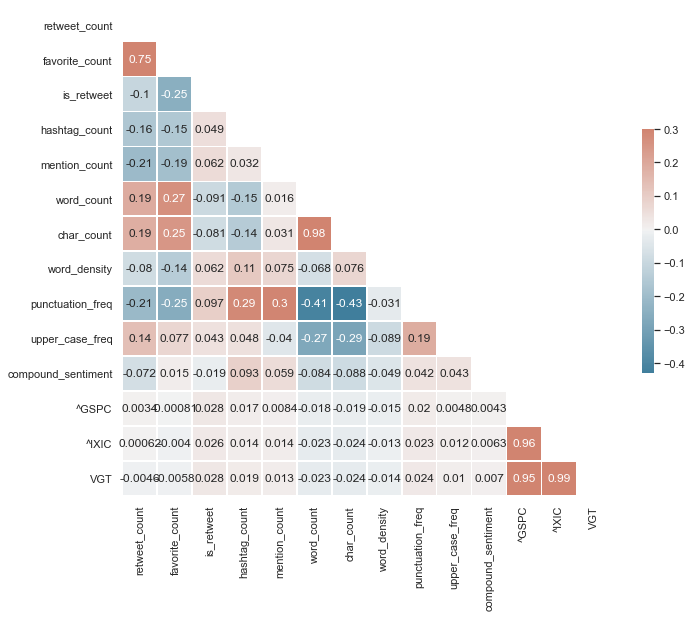

In [11]:
sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

plt.show()

### Normalise features
Normalisation is essential for deep-learning/NN-related tasks. MinMax Scaler is chosen in this case to rescale the numeric inputs.

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
# obtain a list of numeric columns
numeric_cols = list(df.columns)

# remove text and output columns
numeric_cols.remove('cleaned_text')
numeric_cols.remove('^GSPC')
numeric_cols.remove('^IXIC')
numeric_cols.remove('VGT')

In [14]:
# scale the features
scaler = MinMaxScaler() 
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

### Word embedding
Word2Vec is the chosen text embedding method for several reasons:
* The mapping between the target word to its context word implicitly embeds the sub-linear relationship into the vector space of words, so that relationships like “king:man as queen:woman” can be infered by word vectors.
* It is less computationally expensive than deep language models such as GloVe, BERT, ElMo. BERT + transfer learning with BiLSTM was initially chosen for this problem but due to the relatively large dataset and limited computational power, training was extremely slow.

#### Further process text for Word2Vec

In [15]:
import nltk

In [16]:
def process_text_w2v(paragraph):    
    result = list()
    for line in nltk.sent_tokenize(paragraph):
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        tokens = [token for token in tokenizer.tokenize(line)]
        result.append(tokens) 
    return result

In [17]:
df['cleaned_text_w2v'] = df['cleaned_text'].apply(lambda x: process_text_w2v(x))

In [18]:
# compile all sentences together to compose the corpus for later usage.
sentences = [sent for x in df['cleaned_text_w2v'].values.tolist() for sent in x]

#### Set parameters for word2vec model
`min_count` is set to 1 since we would like to obtain the embeddings of all words in our vocabulary for subsequent modelling to work. Normally, `min_count` is set to a larger value.

In [19]:
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

In [20]:
w2v_model = Word2Vec(min_count=1, 
                     window=3,
                     size=64,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count())

#### Building the Vocabulary Table
Digest all the words and filter out the unique words, and doing some basic counts on them.

In [21]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.12 mins


### Train Word2Vec

In [22]:
start_time = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - start_time) / 60, 2)))

Time to train the model: 0.31 mins


In [23]:
w2v_model.save('../model/word2vec/word2vec.model')

In [24]:
w2v_model.init_sims(replace=True)

#### Generate Word2Vec vectors
generate and write the word embedding vectors to directory

In [25]:
# # load the model from the model file
# w2v_model = Word2Vec.load('../model/word2vec.model')

In [26]:
# Store the vectors in a csv file
with open('../model/word2vec/word2vec.csv', 'w+') as word2vec_file:
    
    for index, row in df.iterrows():
        model_vector = (np.mean([w2v_model[token] for token in row['cleaned_text_w2v'][0]], axis=0)).tolist()
        
        if index == 0:
            header = ",".join(str(ele) for ele in range(64))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(64)])
        
        word2vec_file.write(line1)
        word2vec_file.write('\n')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#### Concatenate the word embeddings with other features in the datasets

In [27]:
w2v_embeddings = pd.read_csv('../model/word2vec/word2vec.csv')

In [28]:
df = pd.concat([df, w2v_embeddings], axis=1)

In [29]:
df.head()

,cleaned_text,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,...,54,55,56,57,58,59,60,61,62,63
0,thank,0.053084,0.074713,0.0,0.0,0.1,0.057971,0.085174,0.328571,0.240000,...,-0.045763,0.075537,0.034320,-0.113978,-0.082235,0.023694,-0.108171,0.123489,-0.026809,0.012996
1,big news maine court side rnc uphold ban ballo...,0.079542,0.000000,1.0,0.0,0.0,0.333333,0.432177,0.339286,0.175000,...,-0.009335,-0.031917,0.001181,-0.016655,-0.047610,0.058175,-0.045615,0.028987,-0.156598,0.041495
2,thank paul,0.043277,0.071954,0.0,0.0,0.0,0.043478,0.047319,0.214286,0.150000,...,-0.012806,0.116678,-0.016092,-0.107752,-0.029858,0.014566,-0.046429,0.149606,-0.073625,0.072921
3,defective ballot new york want replace happen ...,0.139217,0.216848,0.0,0.0,0.0,0.594203,0.624606,0.267007,0.071429,...,-0.019787,-0.050878,0.002318,-0.052379,0.024359,-0.000785,-0.014440,0.049268,-0.146037,-0.041080
4,half years secure americas border rebuild awes...,0.051105,0.080530,0.0,0.1,0.0,0.608696,0.750789,0.325581,0.055814,...,0.005815,-0.028766,0.029667,-0.148738,0.011978,-0.016228,0.074570,0.055709,-0.151549,-0.125265


#### Drop `cleaned_text` and `cleaned_text_w2v`

In [30]:
df = df.drop(columns=['cleaned_text', 'cleaned_text_w2v'], errors='ignore')

### Train test split

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
y_GSPC = df['^GSPC']
y_IXIC = df['^IXIC']
y_VGT = df['VGT']
X = df.drop(columns=['^GSPC', '^IXIC', 'VGT'], errors='ignore')

In [33]:
# train is 75% of the entire data set
train_ratio = 0.75

#### GSPC

In [34]:
X_train_GSPC, X_test_GSPC, y_train_GSPC, y_test_GSPC = train_test_split(X, y_GSPC, test_size=1 - train_ratio, random_state=1)

#### IXIC

In [35]:
X_train_IXIC, X_test_IXIC, y_train_IXIC, y_test_IXIC = train_test_split(X, y_IXIC, test_size=1 - train_ratio, random_state=1)

#### VGT

In [36]:
X_train_VGT, X_test_VGT, y_train_VGT, y_test_VGT = train_test_split(X, y_VGT, test_size=1 - train_ratio, random_state=1)

## Modelling - XGBoost 
XGBoost is chosen to be the classification model for a few reasons:
* XGBoost is an ensemble method which helps improve machine learning results by combining and improving on the results from multiple single models.
* As compared to gradient boosting algorithms, XGBoost uses a more regularized model formalization to control over-fitting, which gives it better performance.
* XGBoost is built with the engineering goal to push the limit of computation resources for boosted tree algorithms. It utilises computational power more efficiently for faster, and production-ready training and testing, which is a good choice given the limited computation resources.

In [37]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import mean_squared_error

### Define baseline parameters

In [38]:
params = {'objective':'reg:linear',
          'learning_rate':0.05,
          'n_estimators':200,
          'max_depth':10,
          'min_child_weight':5,
          'gamma':0.1,
          'subsample':0.7,
          'colsample_bytree':0.7,
          'n_jobs':4,
          'random_state':1,
          'seed':1
         }

### Define error metrics

Write a custom function to calculate MAPE, mean average percentage error. MAPE expresses expresses accuracy as a percentage of the error. Because the MAPE is a percentage, it can be easier to understand than the other accuracy measure statistics e.g. RMSE. Refer to the picture below for a guide on the interpretation of MAPE values

<img src="https://www.researchgate.net/profile/Albert_Sese/publication/257812432/figure/tbl1/AS:601657310203931@1520457689632/nterpretation-of-typical-MAPE-values.png" width=300 align="left"/>

In [39]:
# define custom functions to calculate MAPE

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

### GSPC

In [40]:
# initialise an xgboost object
xgb_GSPC = xgboost.XGBModel(**params)

In [41]:
xgb_GSPC.fit(X_train_GSPC, y_train_GSPC,
             eval_set=[(X_train_GSPC, y_train_GSPC), (X_test_GSPC, y_test_GSPC)],
             eval_metric='rmse',
             verbose=50)

[0]	validation_0-rmse:0.475073	validation_1-rmse:0.474663
[50]	validation_0-rmse:0.039876	validation_1-rmse:0.039398
[100]	validation_0-rmse:0.016229	validation_1-rmse:0.015891
[150]	validation_0-rmse:0.015984	validation_1-rmse:0.015707
[199]	validation_0-rmse:0.015983	validation_1-rmse:0.015711


XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.7, gamma=0.1, importance_type='gain',
         learning_rate=0.05, max_delta_step=0, max_depth=10, min_child_weight=5,
         missing=None, n_estimators=200, n_jobs=4, nthread=None,
         objective='reg:linear', random_state=1, reg_alpha=0, reg_lambda=1,
         scale_pos_weight=1, seed=1, silent=True, subsample=0.7)

In [42]:
evals_result_GSPC = xgb_GSPC.evals_result()
evals_result_GSPC

{'validation_0': {'rmse': [0.475073,
   0.451346,
   0.428809,
   0.407401,
   0.387061,
   0.367744,
   0.349389,
   0.331955,
   0.315392,
   0.299674,
   0.284736,
   0.270554,
   0.257076,
   0.244279,
   0.232123,
   0.220575,
   0.209608,
   0.199184,
   0.189293,
   0.179894,
   0.170974,
   0.162501,
   0.154448,
   0.146817,
   0.13956,
   0.132675,
   0.126139,
   0.119936,
   0.114046,
   0.10846,
   0.103162,
   0.098127,
   0.093351,
   0.088826,
   0.084532,
   0.080461,
   0.076604,
   0.072948,
   0.069481,
   0.066198,
   0.063087,
   0.060143,
   0.057346,
   0.054705,
   0.052207,
   0.049849,
   0.047619,
   0.045519,
   0.04353,
   0.041645,
   0.039876,
   0.038205,
   0.036639,
   0.035163,
   0.033779,
   0.032477,
   0.031252,
   0.030113,
   0.029042,
   0.028036,
   0.027095,
   0.026225,
   0.02541,
   0.024653,
   0.023945,
   0.023289,
   0.02268,
   0.02212,
   0.021597,
   0.021116,
   0.020671,
   0.020263,
   0.019891,
   0.019542,
   0.019223,
   0.01

In [43]:
xgb_GSPC.feature_importances_

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:528: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [44]:
xgb_GSPC.predict(X_test_GSPC)

array([0.00022206, 0.00022206, 0.00022206, ..., 0.00022206, 0.00022206,
       0.00022206], dtype=float32)

In [45]:
# # retrieve the RMSE on the test set
mean_squared_error(xgb_GSPC.predict(X_test_GSPC), y_test_GSPC, squared=False) #RMSE

0.01571070620198092

In [46]:
# # retrieve the MAPE on the test set
mean_absolute_percentage_error(y_test_GSPC, xgb_GSPC.predict(X_test_GSPC)) #MAPE

106.10202566075553

#### IXIC

In [37]:
dtrain_IXIC = xgboost.DMatrix(data=X_train_IXIC, label=y_train_IXIC)
dtest_IXIC = xgboost.DMatrix(data=X_test_IXIC, label=y_test_IXIC)

In [38]:
cv_results_IXIC = xgboost.cv(dtrain=dtrain_IXIC, 
                             params=params, 
                             nfold=10, 
                             num_boost_round=200,
                             early_stopping_rounds=10,
                             metrics="rmse", 
                             as_pandas=True,
                             verbose_eval=10,
                             seed=1)

[0]	train-rmse:0.474628+4.25287e-05	test-rmse:0.474628+0.000391236
[10]	train-rmse:0.284525+2.39935e-05	test-rmse:0.284525+0.000415228
[20]	train-rmse:0.170921+2.15184e-05	test-rmse:0.17092+0.000429047
[30]	train-rmse:0.103261+1.30629e-05	test-rmse:0.103261+0.000452604
[40]	train-rmse:0.0633441+1.85065e-05	test-rmse:0.0633425+0.00046824
[50]	train-rmse:0.0403532+2.05271e-05	test-rmse:0.0403506+0.000499508
[60]	train-rmse:0.0278191+3.61786e-05	test-rmse:0.0278149+0.000517897
[70]	train-rmse:0.02162+3.98848e-05	test-rmse:0.0216144+0.000526511
[80]	train-rmse:0.0189079+4.64014e-05	test-rmse:0.0189019+0.000513789
[90]	train-rmse:0.017835+5.0446e-05	test-rmse:0.0178291+0.000494304
[100]	train-rmse:0.0174341+5.00209e-05	test-rmse:0.0174285+0.000480473
[110]	train-rmse:0.0172877+4.99801e-05	test-rmse:0.0172822+0.000470645
[120]	train-rmse:0.0172351+5.07926e-05	test-rmse:0.0172298+0.000463814
[130]	train-rmse:0.017216+5.05193e-05	test-rmse:0.0172109+0.000459839
[140]	train-rmse:0.0172094+5.044

In [39]:
cv_results_IXIC.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
180,0.017205,0.000050,0.0172,0.000455
181,0.017205,0.000050,0.0172,0.000454
182,0.017205,0.000050,0.0172,0.000454
183,0.017205,0.000051,0.0172,0.000454
184,0.017205,0.000051,0.0172,0.000454


In [40]:
cv_results_IXIC['test-rmse-mean'].min()

0.017200100000000003

In [41]:
xgb_IXIC = xgboost.train(
                        params,
                        dtrain_IXIC,
                        num_boost_round=200,
                        evals=[(dtest_IXIC, "Test")],
                        early_stopping_rounds=10,
                        verbose_eval=10
                        )

[0]	Test-rmse:0.474204
Will train until Test-rmse hasn't improved in 10 rounds.
[10]	Test-rmse:0.284085
[20]	Test-rmse:0.170478
[30]	Test-rmse:0.102798
[40]	Test-rmse:0.062866
[50]	Test-rmse:0.039846
[60]	Test-rmse:0.027313
[70]	Test-rmse:0.021149
[80]	Test-rmse:0.018492
[90]	Test-rmse:0.01746
[100]	Test-rmse:0.017095
[110]	Test-rmse:0.016974
[120]	Test-rmse:0.016936
[130]	Test-rmse:0.016927
[140]	Test-rmse:0.016926
Stopping. Best iteration:
[132]	Test-rmse:0.016926



In [42]:
# retrieve the RMSE on the test set
mean_squared_error(xgb_IXIC.predict(dtest_IXIC), y_test_IXIC, squared=False) #RMSE

0.01692609394379573

In [70]:
# retrieve the MAPE on the test set
mean_absolute_percentage_error(y_test_IXIC, xgb_IXIC.predict(dtest_IXIC)) #MAPE

116.91577284046161

#### VGT

In [43]:
dtrain_VGT = xgboost.DMatrix(data=X_train_VGT, label=y_train_VGT)
dtest_VGT = xgboost.DMatrix(data=X_test_VGT, label=y_test_VGT)

In [44]:
cv_results_VGT = xgboost.cv(dtrain=dtrain_VGT, 
                             params=params, 
                             nfold=10, 
                             num_boost_round=200,
                             early_stopping_rounds=10,
                             metrics="rmse", 
                             as_pandas=True,
                             verbose_eval=10,
                             seed=1)

[0]	train-rmse:0.474614+4.77225e-05	test-rmse:0.474615+0.000438783
[10]	train-rmse:0.28459+2.67163e-05	test-rmse:0.284589+0.000465734
[20]	train-rmse:0.17108+2.44508e-05	test-rmse:0.171079+0.000479823
[30]	train-rmse:0.103554+1.45245e-05	test-rmse:0.103553+0.000506038
[40]	train-rmse:0.0638388+1.9999e-05	test-rmse:0.0638367+0.000520913
[50]	train-rmse:0.0411348+2.29425e-05	test-rmse:0.0411317+0.000549458
[60]	train-rmse:0.0289469+4.01533e-05	test-rmse:0.0289424+0.000557033
[70]	train-rmse:0.023054+4.26943e-05	test-rmse:0.0230483+0.000553864
[80]	train-rmse:0.0205328+4.87561e-05	test-rmse:0.0205269+0.000531872
[90]	train-rmse:0.0195494+5.22536e-05	test-rmse:0.0195439+0.000508448
[100]	train-rmse:0.0191846+5.17073e-05	test-rmse:0.0191792+0.000493776
[110]	train-rmse:0.0190513+5.1451e-05	test-rmse:0.0190464+0.000483544
[120]	train-rmse:0.0190037+5.21173e-05	test-rmse:0.0189988+0.000476794
[130]	train-rmse:0.0189863+5.20904e-05	test-rmse:0.0189819+0.000472852
[140]	train-rmse:0.0189803+5.1

In [45]:
cv_results_VGT.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
165,0.018977,0.000052,0.018972,0.000468
166,0.018977,0.000052,0.018972,0.000468
167,0.018977,0.000052,0.018972,0.000468
168,0.018977,0.000052,0.018972,0.000468
169,0.018977,0.000052,0.018972,0.000468


In [46]:
cv_results_VGT['test-rmse-mean'].min()

0.0189721

In [48]:
xgb_VGT = xgboost.train(
                        params,
                        dtrain_VGT,
                        num_boost_round=200,
                        evals=[(dtest_VGT, "Test")],
                        early_stopping_rounds=10,
                        verbose_eval=10
                        )

[0]	Test-rmse:0.47403
Will train until Test-rmse hasn't improved in 10 rounds.
[10]	Test-rmse:0.283986
[20]	Test-rmse:0.170479
[30]	Test-rmse:0.102939
[40]	Test-rmse:0.06322
[50]	Test-rmse:0.040509
[60]	Test-rmse:0.028364
[70]	Test-rmse:0.022556
[80]	Test-rmse:0.020128
[90]	Test-rmse:0.019211
[100]	Test-rmse:0.018896
[110]	Test-rmse:0.018796
[120]	Test-rmse:0.018768
[130]	Test-rmse:0.018763
Stopping. Best iteration:
[127]	Test-rmse:0.018763



In [49]:
# retrieve the RMSE on the test set
mean_squared_error(xgb_VGT.predict(dtest_VGT), y_test_VGT, squared=False) #RMSE

0.018763496376940903

In [66]:
# retrieve the MAPE on the test set
mean_absolute_percentage_error(y_test_VGT, xgb_VGT.predict(dtest_VGT)) #MAPE

125.31275911747726